In [1]:


import calendar
import datetime as dt
from timeit import default_timer as timer

import numpy as np
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
start_time = timer()

In [2]:
df = pd.read_csv('applications data.csv')

In [3]:
df.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,20160101,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,2765,19070626,1797504115,0
1,2,20160101,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,20160101,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,19070626,216537580,0
3,4,20160101,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0
4,5,20160101,24065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,3173,19980315,6101082272,0


In [4]:
df.date = pd.to_datetime(df.date,format='%Y%m%d')

In [5]:
df.dtypes

record                  int64
date           datetime64[ns]
ssn                     int64
firstname              object
lastname               object
address                object
zip5                    int64
dob                     int64
homephone               int64
fraud_label             int64
dtype: object

In [6]:
df.shape

(1000000, 10)

### Clean frivolous fields

In [7]:
df.loc[df.ssn == 999999999, 'ssn'] = df.loc[df.ssn == 999999999, 'record']
df.loc[df.address == '123 MAIN ST', 'address'] = df.loc[df.address == '123 MAIN ST', 'record']
df.loc[df.homephone == 9999999999, 'homephone'] = df.loc[df.homephone == 9999999999, 'record']
df.loc[df.dob == 19070626, 'dob'] = df.loc[df.dob == 19070626, 'record']

In [8]:
df.ssn = df.ssn.astype(str)
df.zip5 = df.zip5.astype(str)
df.dob = df.dob.astype(str)
df.homephone = df.homephone.astype(str)
df.address = df.address.astype(str)

In [9]:
# add leading 0 to zips

df['zip5'] = df.zip5.apply(lambda x: x if len(x) == 5 else '0'*(5-len(x)) + x)

### Risk table for day of week

In [10]:
df['dow'] = df.date.apply(lambda x: calendar.day_name[x.weekday()])

In [11]:
train_test = df[df.date < '2016-11-01']

In [12]:
# do statistical smoothing
c = 4; nmid = 20; y_avg = train_test['fraud_label'].mean()
y_dow = train_test.groupby('dow')['fraud_label'].mean()
num = train_test.groupby('dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1 + np.exp(-(num - nmid)/c))
df['dow_risk'] = df.dow.map(y_dow_smooth)

In [1]:
df['dow_risk']

NameError: name 'df' is not defined

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df1=pd.DataFrame([['Monday',0.01348],['Tuesday',0.01407],['Wednesday',0.015169],['Thursday',0.014981],['Friday',0.014499],['Saturday',0.014968],['Sunday',0.013764]], columns=['dow', 'dow_risk'])
df1

,dow,dow_risk
0,Monday,0.013480
1,Tuesday,0.014070
2,Wednesday,0.015169
3,Thursday,0.014981
4,Friday,0.014499
5,Saturday,0.014968
6,Sunday,0.013764


<Figure size 432x288 with 0 Axes>

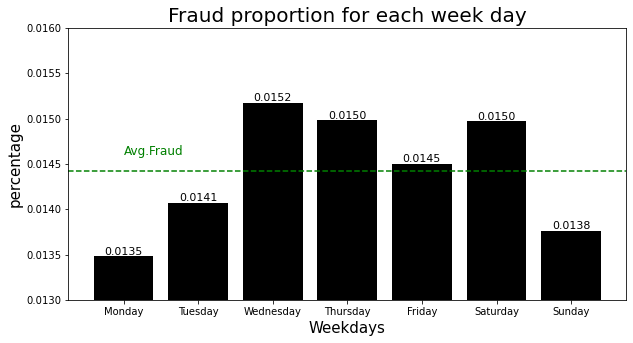

In [15]:
tickpositions=[0.0130,0.0135,0.0140,0.0145,0.0150,0.0155,0.0160]
ticklabels=['0.0130','0.0135','0.0140','0.0145','0.0150','0.0155','0.0160']
fig = plt.figure()
plt.figure(figsize=(10,5))
plt.bar(df1['dow'],df1['dow_risk'],color='black')
plt.xlabel('Weekdays',fontsize=15)
plt.ylabel('percentage',fontsize=15)
plt.title('Fraud proportion for each week day',fontsize=20)
avg_percentage=df1['dow_risk'].mean()
plt.axhline(y=avg_percentage,color='green',linestyle='--')
plt.annotate('Avg.Fraud',(0,0.0146),color='green',fontsize=12)


plt.ylim(0.0130, 0.0160)
plt.yticks(tickpositions,ticklabels)
for a,b in zip(df1['dow'],df1['dow_risk']):
    plt.text(a, b, '%.4f' % b, ha='center', va= 'bottom',fontsize=11)
plt.show()

In [16]:
df.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label,dow,dow_risk
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,02765,1,1797504115,0,Friday,0.014499
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1,Friday,0.014499
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,3,216537580,0,Friday,0.014499
3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0,Friday,0.014499
4,5,2016-01-01,24065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,03173,19980315,6101082272,0,Friday,0.014499


### Create entities

In [17]:
df['name'] = df.firstname + df.lastname
df['fulladdress'] = df.address + df.zip5
df['name_dob'] = df.name + df.dob
df['name_fulladdress'] = df.name + df.fulladdress
df['name_homephone'] = df.name + df.homephone
df['fulladdress_dob'] = df.fulladdress + df.dob
df['fulladdress_homephone'] = df.fulladdress + df.homephone
df['dob_homephone'] = df.dob + df.homephone
df['homephone_name_dob'] = df.homephone + df.name_dob

In [35]:
df

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label,...,dow_risk,name,fulladdress,name_dob,name_fulladdress,name_homephone,fulladdress_dob,fulladdress_homephone,dob_homephone,homephone_name_dob
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,02765,1,1797504115,0,...,0.014499,XRRAMMTRSMJETJMJ,6861 EUTST PL02765,XRRAMMTRSMJETJMJ1,XRRAMMTRSMJETJMJ6861 EUTST PL02765,XRRAMMTRSMJETJMJ1797504115,6861 EUTST PL027651,6861 EUTST PL027651797504115,11797504115,1797504115XRRAMMTRSMJETJMJ1
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1,...,0.014499,MAMSTUJRRTTEMRRR,7280 URASA PL57169,MAMSTUJRRTTEMRRR19340615,MAMSTUJRRTTEMRRR7280 URASA PL57169,MAMSTUJRRTTEMRRR4164239415,7280 URASA PL5716919340615,7280 URASA PL571694164239415,193406154164239415,4164239415MAMSTUJRRTTEMRRR19340615
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,3,216537580,0,...,0.014499,SZMMUJEZSEUSEZRAE,5581 RSREX LN56721,SZMMUJEZSEUSEZRAE3,SZMMUJEZSEUSEZRAE5581 RSREX LN56721,SZMMUJEZSEUSEZRAE216537580,5581 RSREX LN567213,5581 RSREX LN56721216537580,3216537580,216537580SZMMUJEZSEUSEZRAE3
3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0,...,0.014499,SJJZSXRSZETJXTXXS,1387 UJZXJ RD35286,SJJZSXRSZETJXTXXS19440430,SJJZSXRSZETJXTXXS1387 UJZXJ RD35286,SJJZSXRSZETJXTXXS132144161,1387 UJZXJ RD3528619440430,1387 UJZXJ RD35286132144161,19440430132144161,132144161SJJZSXRSZETJXTXXS19440430
4,5,2016-01-01,24065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,03173,19980315,6101082272,0,...,0.014499,SSSXUEJMSSSUUJXUZ,279 EAASA WY03173,SSSXUEJMSSSUUJXUZ19980315,SSSXUEJMSSSUUJXUZ279 EAASA WY03173,SSSXUEJMSSSUUJXUZ6101082272,279 EAASA WY0317319980315,279 EAASA WY031736101082272,199803156101082272,6101082272SSSXUEJMSSSUUJXUZ19980315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999996,2016-12-31,766104848,XUSAAURMZ,EJXXEXZX,8079 EJRUJ AVE,54890,19550418,8236558223,0,...,0.014968,XUSAAURMZEJXXEXZX,8079 EJRUJ AVE54890,XUSAAURMZEJXXEXZX19550418,XUSAAURMZEJXXEXZX8079 EJRUJ AVE54890,XUSAAURMZEJXXEXZX8236558223,8079 EJRUJ AVE5489019550418,8079 EJRUJ AVE548908236558223,195504188236558223,8236558223XUSAAURMZEJXXEXZX19550418
999996,999997,2016-12-31,445178058,SAAJJEMTX,UMAUETJX,4817 UMSXT AVE,74683,19150624,6790134432,0,...,0.014968,SAAJJEMTXUMAUETJX,4817 UMSXT AVE74683,SAAJJEMTXUMAUETJX19150624,SAAJJEMTXUMAUETJX4817 UMSXT AVE74683,SAAJJEMTXUMAUETJX6790134432,4817 UMSXT AVE7468319150624,4817 UMSXT AVE746836790134432,191506246790134432,6790134432SAAJJEMTXUMAUETJX19150624
999997,999998,2016-12-31,25283410,ESRXXRSUX,EUEJRJJE,7562 RJMAZ ST,86805,19880628,3997657622,0,...,0.014968,ESRXXRSUXEUEJRJJE,7562 RJMAZ ST86805,ESRXXRSUXEUEJRJJE19880628,ESRXXRSUXEUEJRJJE7562 RJMAZ ST86805,ESRXXRSUXEUEJRJJE3997657622,7562 RJMAZ ST8680519880628,7562 RJMAZ ST868053997657622,198806283997657622,3997657622ESRXXRSUXEUEJRJJE19880628
999998,999999,2016-12-31,361232148,XXMZSRXMA,RSRSUJSS,3408 UZZAM WY,49183,20120302,5935293731,0,...,0.014968,XXMZSRXMARSRSUJSS,3408 UZZAM WY49183,XXMZSRXMARSRSUJSS20120302,XXMZSRXMARSRSUJSS3408 UZZAM WY49183,XXMZSRXMARSRSUJSS5935293731,3408 UZZAM WY4918320120302,3408 UZZAM WY491835935293731,201203025935293731,5935293731XXMZSRXMARSRSUJSS20120302


In [18]:
for field in list(df.iloc[:,np.r_[3:9, 12:21]].columns):
    df['ssn_' + field] = df.ssn + df[field]

In [19]:
attributes = list(df.iloc[:, np.r_[2, 5, 7, 8, 12:36]].columns)

In [20]:
attributes

['ssn',
 'address',
 'dob',
 'homephone',
 'name',
 'fulladdress',
 'name_dob',
 'name_fulladdress',
 'name_homephone',
 'fulladdress_dob',
 'fulladdress_homephone',
 'dob_homephone',
 'homephone_name_dob',
 'ssn_firstname',
 'ssn_lastname',
 'ssn_address',
 'ssn_zip5',
 'ssn_dob',
 'ssn_homephone',
 'ssn_name',
 'ssn_fulladdress',
 'ssn_name_dob',
 'ssn_name_fulladdress',
 'ssn_name_homephone',
 'ssn_fulladdress_dob',
 'ssn_fulladdress_homephone',
 'ssn_dob_homephone',
 'ssn_homephone_name_dob']

### Velocity + Day since

In [21]:
df1 = df.copy()
final = df.copy()
df1['check_date'] = df1.date
df1['check_record'] = df1.record

In [22]:
start = timer()

for entity in attributes:
    
    st = timer()

    df_l = df1[['record', 'date', entity]]
    df_r = df1[['check_record', 'check_date', entity]]
    temp = pd.merge(df_l, df_r, left_on=entity, right_on=entity)

    # day since
    day_since_df = temp[temp.record > temp.check_record][['record', 'date', 'check_date']] \
        .groupby('record')[['date', 'check_date']].last()
    mapper = (day_since_df.date - day_since_df.check_date).dt.days
    final[entity + '_day_since'] = final.record.map(mapper)
    final[entity + '_day_since'].fillna(365, inplace=True)
    print(f'\n{entity}_day_since ---> Done')

    # velocity
    for offset_t in [0, 1, 3, 7, 14, 30]:
        count_day_df = temp[(temp.check_date >= (temp.date - dt.timedelta(offset_t)))
                            & (temp.record >= temp.check_record)]
        col_name = f'{entity}_count_{offset_t}'
        mapper2 = count_day_df.groupby('record')[entity].count()
        final[col_name] = final.record.map(mapper2)

        print(f'{entity}_count_{str(offset_t)} ---> Done')

    print(f'Run time for entity {entity} ----------------- {timer() - st:0.2f}s')

print(f'Total run time: {(timer() - start) / 60:0.2f}min')


ssn_day_since ---> Done
ssn_count_0 ---> Done
ssn_count_1 ---> Done
ssn_count_3 ---> Done
ssn_count_7 ---> Done
ssn_count_14 ---> Done
ssn_count_30 ---> Done
Run time for entity ssn ----------------- 4.29s

address_day_since ---> Done
address_count_0 ---> Done
address_count_1 ---> Done
address_count_3 ---> Done
address_count_7 ---> Done
address_count_14 ---> Done
address_count_30 ---> Done
Run time for entity address ----------------- 4.19s

dob_day_since ---> Done
dob_count_0 ---> Done
dob_count_1 ---> Done
dob_count_3 ---> Done
dob_count_7 ---> Done
dob_count_14 ---> Done
dob_count_30 ---> Done
Run time for entity dob ----------------- 34.62s

homephone_day_since ---> Done
homephone_count_0 ---> Done
homephone_count_1 ---> Done
homephone_count_3 ---> Done
homephone_count_7 ---> Done
homephone_count_14 ---> Done
homephone_count_30 ---> Done
Run time for entity homephone ----------------- 23.06s

name_day_since ---> Done
name_count_0 ---> Done
name_count_1 ---> Done
name_count_3 ---> 

### Relative Velocity

In [24]:
start = timer()
for att in attributes:
    for d in ['0', '1']:
        for dd in ['3', '7', '14', '30']:
            final[att + '_count_' + d + '_by_' + dd] \
                = final[att + '_count_' + d] / (final[att + '_count_' + dd] / float(dd))
print(f'Total run time: {timer() - start:0.2f}s')

Total run time: 25.12s


### Keep desired variables

In [25]:
final.set_index('record', inplace = True)
final.shape

(1000000, 455)

In [26]:
final.to_csv('final.csv')

In [29]:
df_modeling_scaled = final.loc[((final['date'] < '2016-11-01') & (final['date'] > '2016-01-14'))]

MemoryError: Unable to allocate 1.88 GiB for an array with shape (253, 1000000) and data type float64

In [28]:
numerical_index = final.columns.get_loc("ssn_day_since")+1 #this is the index of the first numerical feature/column in the dataframe
df_numerical = pd.concat([final['fraud_label'],final.iloc[:,numerical_index:]], axis=1)

MemoryError: Unable to allocate 1.25 GiB for an array with shape (168, 1000000) and data type int64

In [97]:
# final2 = final.iloc[:, np.r_[8, 10, 29:337]]
final2 = final.iloc[:, np.r_[8, 10, 29:445]]
final2.shape

(1000000, 418)

In [98]:
final2.head()

,fraud_label,dow_risk,ssn_name_fulladdress,ssn_name_homephone,ssn_fulladdress_dob,ssn_fulladdress_homephone,ssn_dob_homephone,ssn_homephone_name_dob,ssn_day_since,ssn_count_0,...,ssn_fulladdress_homephone_count_1_by_3,ssn_fulladdress_homephone_count_1_by_7,ssn_fulladdress_homephone_count_1_by_14,ssn_fulladdress_homephone_count_1_by_30,ssn_dob_homephone_count_0_by_3,ssn_dob_homephone_count_0_by_7,ssn_dob_homephone_count_0_by_14,ssn_dob_homephone_count_0_by_30,ssn_dob_homephone_count_1_by_3,ssn_dob_homephone_count_1_by_7
record,,,,,,,,,,,,,,,,,,,,,
1,0,0.014499,379070012XRRAMMTRSMJETJMJ6861 EUTST PL02765,379070012XRRAMMTRSMJETJMJ1797504115,3790700126861 EUTST PL027651,3790700126861 EUTST PL027651797504115,37907001211797504115,3790700121797504115XRRAMMTRSMJETJMJ1,365.0,1,...,3.0,7.0,14.0,30.0,3.0,7.0,14.0,30.0,3.0,7.0
2,1,0.014499,387482503MAMSTUJRRTTEMRRR7280 URASA PL57169,387482503MAMSTUJRRTTEMRRR4164239415,3874825037280 URASA PL5716919340615,3874825037280 URASA PL571694164239415,387482503193406154164239415,3874825034164239415MAMSTUJRRTTEMRRR19340615,365.0,1,...,3.0,7.0,14.0,30.0,3.0,7.0,14.0,30.0,3.0,7.0
3,0,0.014499,200332444SZMMUJEZSEUSEZRAE5581 RSREX LN56721,200332444SZMMUJEZSEUSEZRAE216537580,2003324445581 RSREX LN567213,2003324445581 RSREX LN56721216537580,2003324443216537580,200332444216537580SZMMUJEZSEUSEZRAE3,365.0,1,...,3.0,7.0,14.0,30.0,3.0,7.0,14.0,30.0,3.0,7.0
4,0,0.014499,747451317SJJZSXRSZETJXTXXS1387 UJZXJ RD35286,747451317SJJZSXRSZETJXTXXS132144161,7474513171387 UJZXJ RD3528619440430,7474513171387 UJZXJ RD35286132144161,74745131719440430132144161,747451317132144161SJJZSXRSZETJXTXXS19440430,365.0,1,...,3.0,7.0,14.0,30.0,3.0,7.0,14.0,30.0,3.0,7.0
5,0,0.014499,24065868SSSXUEJMSSSUUJXUZ279 EAASA WY03173,24065868SSSXUEJMSSSUUJXUZ6101082272,24065868279 EAASA WY0317319980315,24065868279 EAASA WY031736101082272,24065868199803156101082272,240658686101082272SSSXUEJMSSSUUJXUZ19980315,365.0,1,...,3.0,7.0,14.0,30.0,3.0,7.0,14.0,30.0,3.0,7.0


In [99]:
desvar=final2.iloc[:,2:].describe()

In [100]:
desvar=desvar.transpose().iloc[:, np.r_[1, 2, 3, 7]]

In [102]:
desvar.to_csv('description of variable.csv')

In [103]:
final2.to_csv('vars_418.csv')

In [49]:
print(f'Duration: {(timer() - start_time) / 60: 0.2f} min')

Duration:  35.15 min
